# Testing How Best To Determine Point Removal

In [2]:
import os
import tsplib95
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import signal
import tqdm
from multiprocess import Pool
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import *
from scipy.stats import ttest_ind
from statistics import mean
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.neighbors import KernelDensity

from wsp import tsp, ds

INCLUDE_LEAVES = False
# FILE_DIR, N = "DATA_GEN_20p0.25", 20
# FILE_DIR, N = "DATA_GEN_30p0.33", 30
FILE_DIR, N = "DATA_GEN_50u", 50
AX = np.array([None, None])
S_FACTOR = 2.0
S_FACTOR_B = 8.0
TREE_TYPE = ds.PKPRQuadTree

In [3]:
top_problems = sorted(os.listdir(FILE_DIR))

len(top_problems)

1000

## Problem Injestion

In [4]:
def filter_leaves(decomp):
    return all(not tree.leaf for tree in decomp[0]) if not INCLUDE_LEAVES else True

def count_wspd(wspd):
    return sum(1 for x in wspd if filter_leaves(x))

def rel_diff(a,b):
    return float('nan') if a == 0 and b == 0 else (a - b) / (a + b)

In [5]:
base_df = pd.DataFrame(columns=['name', 'parent', 'path_reduction', 'path_discount', 'optimal_percent', 'wsp_reduction', 'wsp_reduction_B', 'wsp_spec_reduction', 'wsp_spec_reduction_B', 'point_specific_wsp', 'point_specific_wsp_B', 'point_specific_wsp_weighted', 'point_specific_wsp_weighted_B', 'point_specific_sep_avg', 'point_specific_sep_avg_B', 'point_average_cost', 'point_maximum_cost', 'point_minimum_cost', 'point_average_cost_weighted', 'point_maximum_cost_weighted', 'point_minimum_cost_weighted'])
base_df = base_df.astype({'name': str, 'parent': str, 'path_reduction': float, 'path_discount': float, 'optimal_percent': float, 'wsp_reduction': float, 'wsp_reduction_B': float, 'wsp_spec_reduction': float, 'wsp_spec_reduction_B': float, 'point_specific_wsp': float, 'point_specific_wsp_B': float, 'point_specific_wsp_weighted': float, 'point_specific_wsp_weighted_B': float, 'point_specific_sep_avg': float, 'point_specific_sep_avg_B': float, 'point_average_cost': float, 'point_maximum_cost': float, 'point_minimum_cost': float, 'point_average_cost_weighted': float, 'point_maximum_cost_weighted': float, 'point_minimum_cost_weighted': float})
base_df.set_index('name', inplace=True)

In [6]:
removed_problems : list[tsplib95.models.StandardProblem] = []
def setup(top_problem):
    main_problem = tsplib95.load(f"{FILE_DIR}/{top_problem}/{top_problem}.tsp")
    main_conc_cost = float(main_problem.comment.split(' ')[2])
    main_points = [ds.Point(*main_problem.node_coords[i]) for i in main_problem.get_nodes()]
    
    main_problem_object = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, main_points, AX, s=S_FACTOR)
    main_problem_object_B = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, main_points, AX, s=S_FACTOR_B)
    
    main_cost = main_problem_object.calc_dist(
        [main_points[i-1] for i in main_problem.tours[0]] + [main_points[main_problem.tours[0][0] - 1]]
    )

    updates = base_df.copy()
    
    best_discount = float('inf')
    for removal_name in os.listdir(f"{FILE_DIR}/{top_problem}"): # need to filter in only single point removals here
        if '_' not in removal_name: continue
        point_number = int(removal_name.split('_')[-1].split('.')[0]) # number of the missing point in the og

        sub_problem = tsplib95.load(f"{FILE_DIR}/{top_problem}/{removal_name}")
        sub_conc_cost = float(sub_problem.comment.split(' ')[2])
        sub_points = [ds.Point(*sub_problem.node_coords[i]) for i in sub_problem.get_nodes()]
        sub_problem_object = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, sub_points, AX, s=S_FACTOR)
        sub_problem_object_B = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, sub_points, AX, s=S_FACTOR_B)
        sub_cost = sub_problem_object.calc_dist(
            [sub_points[i-1] for i in sub_problem.tours[0]] + [sub_points[sub_problem.tours[0][0] - 1]]
        )

        point_specific_wsp = sum(
            sum(1 for connectionTree in connections if (not connectionTree.leaf) or INCLUDE_LEAVES)
            for tree, connections in main_problem_object.single_indexable_wspd.items()
            if (INCLUDE_LEAVES or not tree.leaf) and main_points[point_number - 1] in tree
        )
        point_specific_wsp_B = sum(
            sum(1 for connectionTree in connections if connectionTree.leaf or INCLUDE_LEAVES)
            for tree, connections in main_problem_object_B.single_indexable_wspd.items()
            if (INCLUDE_LEAVES or not tree.leaf) and main_points[point_number - 1] in tree
        )
        
        point_specific_wsp_sep_avg = float('nan') if next(iter(filter(lambda pair: any(main_points[point_number - 1] in tree for tree in pair) and (INCLUDE_LEAVES or all(not tree.leaf for tree in pair)), main_problem_object.pair_sep_dict)), None) is None else mean(
            special.sep for pair, special in main_problem_object.pair_sep_dict.items()
            if any(main_points[point_number - 1] in tree for tree in pair) and (INCLUDE_LEAVES or all(not tree.leaf for tree in pair))
        )
        
        point_specific_wsp_sep_avg_B = float('nan') if next(iter(filter(lambda pair: any(main_points[point_number - 1] in tree for tree in pair) and (INCLUDE_LEAVES or all(not tree.leaf for tree in pair)), main_problem_object_B.pair_sep_dict)), None) is None else mean(
            special.sep for pair, special in main_problem_object_B.pair_sep_dict.items()
            if any(main_points[point_number - 1] in tree for tree in pair) and (INCLUDE_LEAVES or all(not tree.leaf for tree in pair))
        )
        
        point_edge_costs = main_problem_object.dist_matrix_with_nan[point_number - 1]
        
        best_discount = min(best_discount, (sub_conc_cost / main_conc_cost))

        updates.loc[sub_problem.name] = {
            'parent': top_problem,
            'path_reduction': sub_conc_cost / main_conc_cost,
            'path_discount': 1.0 - (sub_conc_cost / main_conc_cost),
            'wsp_spec_reduction': rel_diff(count_wspd(main_problem_object.wspd), count_wspd(sub_problem_object.wspd)),
            'wsp_spec_reduction_B': rel_diff(count_wspd(main_problem_object_B.wspd), count_wspd(sub_problem_object_B.wspd)),
            'point_specific_wsp': point_specific_wsp,
            'point_specific_wsp_B': point_specific_wsp_B,
            'point_specific_wsp_weighted': point_specific_wsp / (count_wspd(main_problem_object.wspd) + 0.01),
            'point_specific_wsp_weighted_B': point_specific_wsp_B / (count_wspd(main_problem_object_B.wspd) + 0.01),
            'point_specific_sep_avg': point_specific_wsp_sep_avg,
            'point_specific_sep_avg_B': point_specific_wsp_sep_avg_B,
            'point_average_cost': np.nanmean(point_edge_costs),
            'point_maximum_cost': np.nanmax(point_edge_costs),
            'point_minimum_cost': np.nanmin(point_edge_costs),
            'point_average_cost_weighted': np.nanmean(point_edge_costs) / main_cost,
            'point_maximum_cost_weighted': np.nanmax(point_edge_costs) / main_cost,
            'point_minimum_cost_weighted': np.nanmin(point_edge_costs) / main_cost,
        }
    updates['optimal_percent'] = updates['path_discount'] / best_discount
    return updates

original_sigint_handler = signal.signal(signal.SIGINT, signal.SIG_IGN)
pool = Pool(7) # NUMBER OF PROCESSES
signal.signal(signal.SIGINT, original_sigint_handler)

update_collection = []
u=0
try:
    with tqdm.tqdm(total=len(top_problems), unit="top problem") as pbar:
        for result in pool.imap_unordered(setup, top_problems):
            update_collection.append(result)
            pbar.update(1)
            prob_name = next(iter(result))
            u += 1
            # if result[prob_name] != {}:
            #     u += 1
            #     # pbar.set_postfix(pf := {**pf, **{"last": prob_name, "last_updated": prob_name, "updated": u}})
            # else:
            #     # pbar.set_postfix(pf := {**pf, **{"last": prob_name}})
except KeyboardInterrupt:
    print("Caught KeyboardInterrupt, terminating workers")
    pool.terminate()
else:
    pool.close()
pool.join()

print("Injesting updates")
reduction_df = pd.concat(update_collection)
reduction_df

100%|██████████| 1000/1000 [01:58<00:00,  8.45top problem/s]

Injesting updates


,parent,path_reduction,path_discount,optimal_percent,wsp_reduction,wsp_reduction_B,wsp_spec_reduction,wsp_spec_reduction_B,point_specific_wsp,point_specific_wsp_B,point_specific_wsp_weighted,point_specific_wsp_weighted_B,point_specific_sep_avg,point_specific_sep_avg_B,point_average_cost,point_maximum_cost,point_minimum_cost,point_average_cost_weighted,point_maximum_cost_weighted,point_minimum_cost_weighted
name,,,,,,,,,,,,,,,,,,,,
aad50u_16,aad50u,0.997798,0.002202,0.002331,NaN,NaN,0.000000,-0.076923,12,19,0.168990,0.633122,1.882531,1.606783,4376.997178,9480.812834,435.183869,0.075897,0.164398,0.007546
aad50u_4,aad50u,0.998405,0.001595,0.001689,NaN,NaN,0.083969,0.111111,11,23,0.154908,0.766411,2.465781,1.864900,4894.349058,8858.516637,735.312859,0.084868,0.153607,0.012750
aad50u_5,aad50u,0.999185,0.000815,0.000863,NaN,NaN,0.028986,0.071429,9,21,0.126743,0.699767,1.541157,1.518234,4066.340064,7575.575556,451.453209,0.070510,0.131361,0.007828
aad50u_17,aad50u,0.998387,0.001613,0.001707,NaN,NaN,0.007092,0.090909,12,31,0.168990,1.032989,1.722926,2.145411,4235.493536,9091.319431,262.840256,0.073444,0.157644,0.004558
aad50u_29,aad50u,0.994486,0.005514,0.005838,NaN,NaN,-0.006993,0.000000,10,2,0.140825,0.066644,1.589752,1.042423,4363.622482,8778.322220,977.896723,0.075665,0.152216,0.016957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bml50u_8,bml50u,0.994627,0.005373,0.005585,NaN,NaN,0.000000,0.000000,11,0,0.134130,0.000000,2.077060,NaN,6211.741015,9792.106617,1654.786995,0.116297,0.183329,0.030981
bml50u_22,bml50u,0.982831,0.017169,0.017844,NaN,NaN,-0.006061,0.000000,8,0,0.097549,0.000000,1.601653,NaN,5463.519733,10977.349862,801.355102,0.102289,0.205520,0.015003
bml50u_36,bml50u,0.994027,0.005973,0.006207,NaN,NaN,0.025000,-0.056911,13,18,0.158517,0.310291,1.899660,1.984964,5738.957590,10631.827736,721.208014,0.107446,0.199051,0.013503


In [7]:
ge0_reduc_df = reduction_df[reduction_df['point_specific_wsp'] > 0]
reduction_df['wsp_spec_reduction'].describe(), reduction_df['wsp_spec_reduction'].isna().sum()
# reduction_df = reduction_df[reduction_df['wsp_spec_reduction'].notna()]

(count    50000.000000
 mean         0.017026
 std          0.030522
 min         -0.238095
 25%          0.000000
 50%          0.005988
 75%          0.031056
 max          0.251613
 Name: wsp_spec_reduction, dtype: float64,
 np.int64(0))

## WSP Reduction Calculations
How much does the difference in global well seperated pairs actually predict anything

In [8]:
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["wsp_spec_reduction"])).fit()
print(results.summary())

results_B = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df[["wsp_spec_reduction", "wsp_spec_reduction_B"]])).fit()
results_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 1.373e-06
Date:                Mon, 09 Jun 2025   Prob (F-statistic):              0.999
Time:                        23:03:11   Log-Likelihood:             1.5991e+05
No. Observations:               50000   AIC:                        -3.198e+05
Df Residuals:                   49998   BIC:                        -3.198e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9912   5.06

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     1482.
Date:                Mon, 09 Jun 2025   Prob (F-statistic):               0.00
Time:                        23:03:11   Log-Likelihood:             1.6134e+05
No. Observations:               50000   AIC:                        -3.227e+05
Df Residuals:                   49997   BIC:                        -3.227e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.9905   5.05e-05   1.96e+04      0.000       0.990       0.991
wsp_spec_reduction      -0.0487      0.002    -29.210      0.000      -0.052      -0.045
wsp_spec_reduction_B     0.0529      0.001     54.437      0.000       0.051       0.055
==============================================================================
Omnibus:                    21886.944   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           128141.540
Skew:                          -2.046   Prob(JB):                         0.00
Kurtosis:                       9.691   Cond. No.                         41.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
results2 = smf.ols(formula="path_reduction ~ wsp_spec_reduction + I(wsp_spec_reduction**2)", data=reduction_df).fit()
print(results2.summary())

results2_B = smf.ols(formula="path_reduction ~ wsp_spec_reduction + I(wsp_spec_reduction**2) + wsp_spec_reduction_B + I(wsp_spec_reduction_B**2)", data=reduction_df).fit()
results2_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     862.3
Date:                Mon, 09 Jun 2025   Prob (F-statistic):               0.00
Time:                        23:03:11   Log-Likelihood:             1.6075e+05
No. Observations:               50000   AIC:                        -3.215e+05
Df Residuals:                   49997   BIC:                        -3.215e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     1138.
Date:                Mon, 09 Jun 2025   Prob (F-statistic):               0.00
Time:                        23:03:11   Log-Likelihood:             1.6208e+05
No. Observations:               50000   AIC:                        -3.242e+05
Df Residuals:                   49995   BIC:                        -3.241e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.9909   5.09e-05   1.95e+04      0.000       0.991       0.991
wsp_spec_reduction              -0.0139      0.002     -5.912      0.000      -0.019      -0.009
I(wsp_spec_reduction ** 2)      -0.5675      0.026    -22.118      0.000      -0.618      -0.517
wsp_spec_reduction_B             0.0591      0.001     51.239      0.000       0.057       0.061
I(wsp_spec_reduction_B ** 2)    -0.1328      0.007    -18.875      0.000      -0.147      -0.119
==============================================================================
Omnibus:                    21163.408   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           123216.278
Skew:                          -1.966   Prob(JB):                         0.00
Kurtosis:                       9.609   Cond. No.                         613.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_92910/1037681458.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_92910/1037681458.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


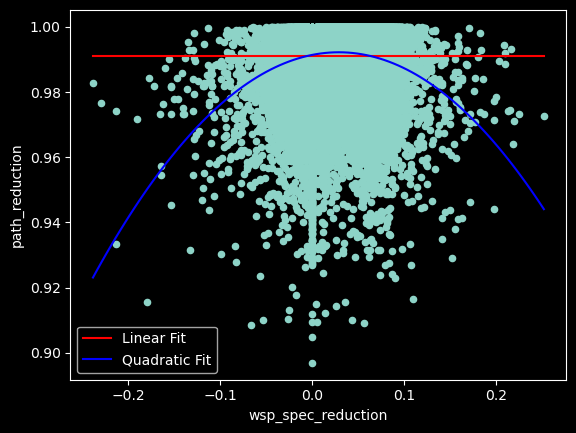

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_92910/1037681458.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]


np.float64(0.9911664158060505)

In [10]:
reduction_df.plot.scatter("wsp_spec_reduction", "path_reduction")
# Plot the first fitted model
x = np.linspace(reduction_df["wsp_spec_reduction"].min(), reduction_df["wsp_spec_reduction"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

In [11]:
reduction_df["wsp_spec_reduction"].values

array([0.        , 0.08396947, 0.02898551, ..., 0.025     , 0.        ,
       0.        ], shape=(50000,))

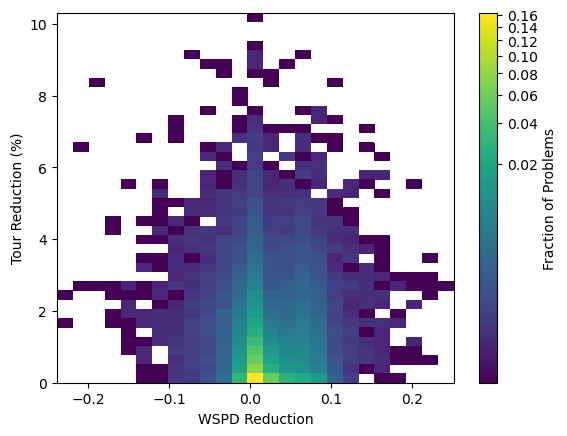

In [13]:
# dummy plot for no output

plt.style.use('default')  # Use the default (light) matplotlib style

h = plt.hist2d(
    reduction_df["wsp_spec_reduction"],
    100 * reduction_df["path_discount"],
    norm=PowerNorm(0.25),
    bins=(25,40),
    density=False,
    cmin=1,
)

h_norm = h[0] / len(reduction_df["wsp_spec_reduction"])
norm = PowerNorm(0.25)
im = plt.imshow(
    h_norm.T,
    origin='lower',
    extent=[h[1][0], h[1][-1], h[2][0], h[2][-1]],
    aspect='auto',
    norm=norm,
)
plt.colorbar(im, label='Fraction of Problems')
plt.xlabel('WSPD Reduction')
plt.ylabel('Tour Reduction (%)')

plt.gcf().patch.set_alpha(0)
plt.gca().patch.set_alpha(0)
plt.show()

### Discount class predictions

In [11]:
COMPARISON_SIZE = 5
path_smallest = reduction_df.groupby("parent").apply(lambda df: df.nsmallest(COMPARISON_SIZE, 'path_reduction'))
path_largest = reduction_df.groupby("parent").apply(lambda df: df.nlargest(2*COMPARISON_SIZE, 'path_reduction'))

clf_df = pd.concat([
    path_smallest.assign(target=1),
    path_largest.assign(target=0)
])

# Create y to match clf_df
y = clf_df['target']

# Ensure problems with the same parent are either all in train or all in test
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
groups = clf_df['parent']
train_idx, test_idx = next(gss.split(clf_df, y, groups=groups))

X_train, X_test = clf_df.iloc[train_idx].reset_index(drop=True, level='parent'), clf_df.iloc[test_idx].reset_index(drop=True, level='parent')
y_train, y_test = y.iloc[train_idx].reset_index(drop=True, level='parent'), y.iloc[test_idx].reset_index(drop=True, level='parent')

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_35241/2242673457.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  path_smallest = reduction_df.groupby("parent").apply(lambda df: df.nsmallest(COMPARISON_SIZE, 'path_reduction'))
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_35241/2242673457.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  path_largest = reduction_df.groupby("pare

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_35241/1986339396.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_35241/1986339396.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     29.49
Date:                Mon, 09 Jun 2025   Prob (F-statistic):           1.86e-13
Time:                        11:19:47   Log-Likelihood:                 15542.
No. Observations:                5000   AIC:                        -3.108e+04
Df Residuals:                    4997   BIC:                        -3.106e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.9695      0.000   5576.139      0.000       0.969       0.970
wsp_spec_reduction             0.0170      0.004      3.997      0.000       0.009       0.025
I(wsp_spec_reduction ** 2)    -0.3264      0.043     -7.679      0.000      -0.410      -0.243
==============================================================================
Omnibus:                     1661.372   Durbin-Watson:                   1.708
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5916.613
Skew:                          -1.653   Prob(JB):                         0.00
Kurtosis:                       7.180   Cond. No.                         278.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

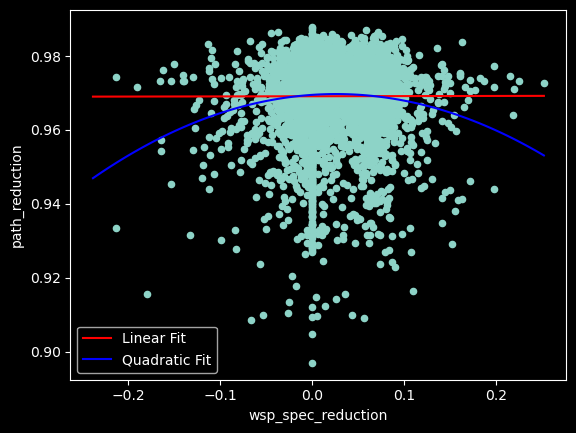

In [12]:
path_smallest.plot.scatter("wsp_spec_reduction", "path_reduction")
results = sm.OLS(path_smallest["path_reduction"], sm.add_constant(path_smallest["wsp_spec_reduction"])).fit()

x = np.linspace(reduction_df["wsp_spec_reduction"].min(), reduction_df["wsp_spec_reduction"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

results2 = smf.ols(formula="path_reduction ~ wsp_spec_reduction + I(wsp_spec_reduction**2)", data=path_smallest).fit()
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')
plt.legend()

results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6979
Date:                Mon, 09 Jun 2025   Prob (F-statistic):              0.404
Time:                        11:19:47   Log-Likelihood:                 60747.
No. Observations:               10000   AIC:                        -1.215e+05
Df Residuals:                    9998   BIC:                        -1.215e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9995   6.72e-06   1.49e+05      0.000       0.999       1.000
wsp_spec_reduction     0.0002      0.000      0.835      0.404      -0.000       0.001
==============================================================================
Omnibus:                     3640.175   Durbin-Watson:                   0.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13399.398
Skew:                          -1.825   Prob(JB):                         0.00
Kurtosis:                       7.340   Cond. No.                         38.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

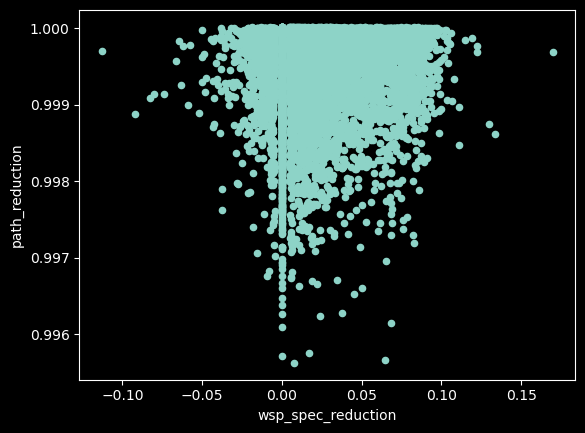

In [13]:
path_largest.plot.scatter("wsp_spec_reduction", "path_reduction")
results = sm.OLS(path_largest["path_reduction"], sm.add_constant(path_largest["wsp_spec_reduction"])).fit()
results.summary()

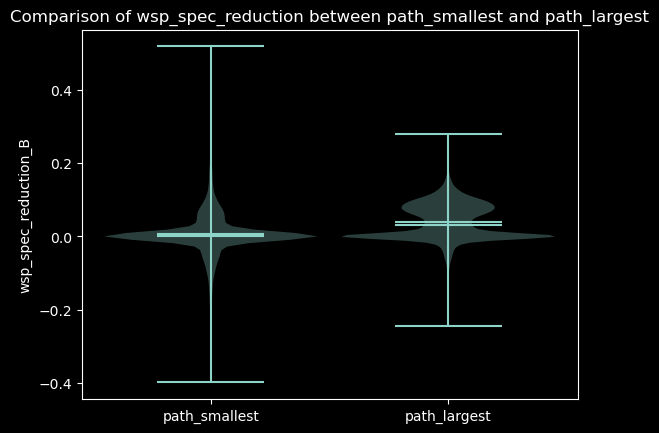

T-statistic: -32.1461, p-value: 2.471e-213
The means are statistically significantly different (p < 0.05).


In [31]:
# Create a DataFrame for violin plot comparison
violin_data = [
    path_smallest['wsp_spec_reduction_B'],
    path_largest['wsp_spec_reduction_B']
]

plt.violinplot(violin_data, showmedians=True, showmeans=True, showextrema=True, points=100, widths=0.9)
plt.xticks([1, 2], ['path_smallest', 'path_largest'])
plt.ylabel('wsp_spec_reduction_B')
plt.title('Comparison of wsp_spec_reduction between path_smallest and path_largest')
plt.show()

# Perform independent t-test
stat, p_value = ttest_ind(
    path_smallest['wsp_spec_reduction_B'],
    path_largest['wsp_spec_reduction_B'],
    nan_policy='omit',
    equal_var=False  # Use Welch's t-test if variances are unequal
)

print(f"T-statistic: {stat:.4f}, p-value: {p_value:.4g}")
if p_value < 0.05:
    print("The means are statistically significantly different (p < 0.05).")
else:
    print("No statistically significant difference between means (p >= 0.05).")

In [16]:
# Subscript the training data
X_train_reduc, X_test_reduc = X_train[['wsp_spec_reduction', 'wsp_spec_reduction_B']].values, X_test[['wsp_spec_reduction', 'wsp_spec_reduction_B']].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[ 15.15189067 -16.833029  ]] [0.1165593]
              precision    recall  f1-score   support

           0       0.85      0.56      0.67      1500
           1       0.47      0.79      0.59       750

    accuracy                           0.64      2250
   macro avg       0.66      0.68      0.63      2250
weighted avg       0.72      0.64      0.65      2250

ROC AUC: 0.7238275555555556


We are able to do a fair job of predicting whether the number of wsps the problem is reduced by has a predictive effect on the shortness of the problem. 

In [28]:
# Fit KDE for each class
kde_1 = KernelDensity(kernel='exponential', bandwidth=0.005)
kde_0 = KernelDensity(kernel='exponential', bandwidth=0.005)

# Use the same features as before
X_train_1 = X_train_reduc[y_train == 1]
X_train_0 = X_train_reduc[y_train == 0]

kde_1.fit(X_train_1)
kde_0.fit(X_train_0)

# Compute log density scores for test set
log_dens_1 = kde_1.score_samples(X_test_reduc)
log_dens_0 = kde_0.score_samples(X_test_reduc)

# Predict class by comparing log densities
y_kde_pred = (log_dens_1 > log_dens_0).astype(int)


print(classification_report(y_test, y_kde_pred))
print("ROC AUC:", roc_auc_score(y_test, log_dens_1 - log_dens_0))

              precision    recall  f1-score   support

           0       0.88      0.57      0.69      1500
           1       0.49      0.84      0.62       750

    accuracy                           0.66      2250
   macro avg       0.69      0.71      0.66      2250
weighted avg       0.75      0.66      0.67      2250

ROC AUC: 0.7852337777777778


## How much does the wsps on a specific point actually matter

In [ ]:
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["point_specific_wsp"])).fit()
print(results.summary())

results_B = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df[["point_specific_wsp", "point_specific_wsp_B"]])).fit()
results_B.summary()

In [ ]:
results2 = smf.ols(formula="path_reduction ~ point_specific_wsp + I(point_specific_wsp**2)", data=reduction_df).fit()
print(results2.summary())

results2_B = smf.ols(formula="path_reduction ~ point_specific_wsp + I(point_specific_wsp**2) + point_specific_wsp_B + I(point_specific_wsp_B**2)", data=reduction_df).fit()
results2_B.summary()

In [ ]:
reduction_df.plot.scatter("point_specific_wsp", "path_reduction")
# Plot the first fitted model
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["point_specific_wsp"])).fit()
x = np.linspace(reduction_df["point_specific_wsp"].min(), reduction_df["point_specific_wsp"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
results2 = smf.ols(formula="path_reduction ~ point_specific_wsp + I(point_specific_wsp**2)", data=reduction_df).fit()
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
x = np.linspace(reduction_df["point_specific_wsp_weighted"].min(), reduction_df["point_specific_wsp_weighted"].max(), 100)
y = np.linspace(reduction_df["point_specific_wsp_weighted_B"].min(), reduction_df["point_specific_wsp_weighted_B"].max(), 100)
X, Y = np.meshgrid(x, y)
Z = 1 - (results2_B.params[0] + results2_B.params[1] * X + results2_B.params[2] * X**2 + results2_B.params[3] * Y + results2_B.params[4] * Y**2)
# ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)
# Plot the scatter points
# ax.scatter(reduction_df["point_specific_wsp_weighted"], reduction_df["point_specific_wsp_weighted_B"], 1 - reduction_df["path_reduction"], color='r', alpha=0.1)
ax.tricontour(reduction_df["point_specific_wsp_weighted"], reduction_df["point_specific_wsp_weighted_B"], 1 - reduction_df["path_reduction"], 40, cmap='viridis')
ax.set_xlabel('WSP Reduction')
ax.set_ylabel('WSP Reduction B')
ax.set_zlabel('Path Reduction')

ax.view_init(azim=50, elev=30)

plt.show()

In [ ]:
median = reduction_df['point_specific_wsp'].median()
q1 = reduction_df['point_specific_wsp'].quantile(0.25)
q3 = reduction_df['point_specific_wsp'].quantile(0.75)

data = [
    reduction_df[reduction_df['point_specific_wsp'] <= median]['path_reduction'],
    reduction_df[(reduction_df['point_specific_wsp'] > median) & (reduction_df['point_specific_wsp'] <= q3)]['path_reduction'],
    reduction_df[reduction_df['point_specific_wsp'] > q3]['path_reduction']
]

plt.violinplot(data, widths=0.9, points=100, showmeans=True, showmedians=True, showextrema=True)
plt.xticks([1, 2, 3], ['point_specific_wsp <= median', 'point_specific_wsp > median and <= Q3', 'point_specific_wsp > Q3'])
plt.ylabel('path_reduction')
plt.title('Path Reduction by Point Specific WSP Groups')
plt.show()

In [ ]:
h = plt.hist2d(ge0_reduc_df["point_specific_wsp"], ge0_reduc_df["path_reduction"], bins=(16,35), cmin=1, norm=PowerNorm(0.25))
plt.colorbar(h[3])

## How well do other geometric tools work for this

In [ ]:
variable = "point_specific_wsp_weighted"

results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df[variable])).fit()
results.summary()

In [ ]:
results2 = smf.ols(formula=f"path_reduction ~ {variable} + I({variable}**2)", data=reduction_df).fit()
results2.summary()

In [ ]:
reduction_df.plot.scatter(variable, "path_reduction")
# Plot the first fitted model
x = np.linspace(reduction_df[variable].min(), reduction_df[variable].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

In [ ]:
results2 = smf.ols(formula=f"optimal_percent ~ point_specific_wsp_weighted + I(point_specific_wsp_weighted**2) + point_average_cost_weighted + I(point_average_cost_weighted**2) + point_maximum_cost_weighted + point_maximum_cost_weighted + I(point_maximum_cost_weighted**2) + point_minimum_cost_weighted", data=reduction_df).fit()
results2.summary()

In [ ]:
pca = sm.PCA(reduction_df[["point_specific_wsp_weighted", "point_average_cost_weighted", "point_maximum_cost_weighted", "point_minimum_cost_weighted"]][:5000].T)

pca.factors

In [ ]:
reduction_df.plot.scatter("point_specific_wsp_weighted", "point_maximum_cost_weighted")